<a href="https://colab.research.google.com/github/EBoumari/dsss_homework_2nd/blob/main/exercise-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert-block alert-info alert"> Hello! If this is your first assignment please read the following instructions:

Read the questions carefully and code what is asked in the respective code block whenever you see a ``` #TODO: YOUR CODE HERE. ```
It is important to do the Coding tasks IN ORDER, as the majority of coding blocks are dependent on the
previous coding blocks in the notebook.
Please also note that there is a **raise NotImplementedError()** for each task or function you have to
implement, so don't forget to remove it before testing your code, otherwise you will always get a "not
implemented" error.

You need to manually upload the data used in this exercise to Colab. Just create a folder 'data' and paste the respective files into this folder. Otherwise, you will get a 'File not found' error. You can find the data in StudOn.

Aside from coding blocks, there are also testing blocks to check whether your implementations
are correct, you can run them but do not change the code inside of them.
The tests are determined via the ASSERT STATEMENTS that you see on the testing blocks, which can help you
out during the coding of the exercises. If you pass all the visible asserts, you will probably get a good
grade on the exercise, just remember that there are also hidden tests, so hardcoding the assert statements
won't help you.

REMEMBER: This Colab notebook DOES NOT HAVE AN AUTOSAVE FUNCTION, so whenever you want to close it, please
remember to save it by clicking on the "file" tab in the upper left corner of the page, followed by
clicking on the "Save a copy to GitHub" button and selecting your corresponding GitHub repository:
"madlab-biosig/exercise-x-YourGitHubUsername"

Before you save the final version of your assignment, please make sure everything runs as expected.
First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all
cells** (in the menubar, select Cell$\rightarrow$Run All).
</div>

### BioSig Exercises WS 23/24
---

# Exercise 10

In [88]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
#%matplotlib widget

# If you are using Jupyter Notebook
# %matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import signal

## Ex 10.1: Pan-Tompkins 2 - Combining the filters and correcting shifts
In last exercise we implemented all filter stages of the Pan-Tompkins algorithm.
Now we want to combine them to easily apply the algorithm to multiple signals.

a) Create a function that applies all filter stages of the Pan Tompkins one after the other.

b) Look at the lecture (or the paper from Pan and Tompkins) and look up the delay of each individual filter stage.
Implement a correction for this shift into your filter function. Verify the result using one of the example data files.

Note, that the Pan-Tompkins Algorithm does **not** correct the group-delay of the final MA-filter (half the window size).
It is implicitly considered in the way the output is interpreted.

### Hint:

b) From the paper we learn the following values:

| Filter    | Delay      |
|:----------|:-----------|
| Lowpass   | __ samples |
| Highpass  | __ samples |
| Derivative| __ samples |
| Overall   | __ samples |





In [89]:
#a) Pan-Tompkins filtering steps

def lowpass_filter(ecg_signal):
    # YOUR CODE HERE
    b_lowpass = np.array([1. / 32, 0, 0, 0, 0, 0, -2. / 32, 0, 0, 0, 0, 0, 1. / 32])
    a_lowpass = np.array([1.0, -2.0, 1.0] + [0] * 10)
    ecg_signal = signal.lfilter(b_lowpass, a_lowpass, ecg_signal)

    return ecg_signal

def highpass_filter(ecg_signal):

    a_highpass = np.zeros([33])
    a_highpass[0] = 1
    a_highpass[1] = -1
    b_highpass = np.zeros([33])
    b_highpass[0] = -1 / 32
    b_highpass[16] = 1
    b_highpass[17] = -1
    b_highpass[32] = 1 / 32
    ecg_signal = signal.lfilter(b_highpass, a_highpass, ecg_signal)

    return ecg_signal

def derivative_operator(ecg_signal):
    # TODO: YOUR CODE HERE
    # YOUR CODE HERE
    a_diff = np.array([1, 0, 0, 0, 0])
    b_diff = np.array([1./4, 1./8, 0, -1./8, -1./4])
    ecg_signal = signal.lfilter(b_diff, a_diff, ecg_signal)
    return(ecg_signal)


def squaring(ecg_signal):
    # TODO: YOUR CODE HERE
    # YOUR CODE HERE
    ecg_signal = ecg_signal ** 2

    return(ecg_signal)

def moving_window_integrator(ecg_signal):
    # TODO: YOUR CODE HERE
    # YOUR CODE HERE
    a_int = np.zeros(30)
    a_int[0] = 1
    b_int = np.ones(30) * 1/30
    ecg_signal = signal.lfilter(b_int, a_int, ecg_signal)

    return(ecg_signal)

#b) Calculate Group delay correction
def group_delay_correction(ecg_signal):
    # Correct the group delay by removing the correct amount of samples from the beginning of the output
    # Pad the same number of zeros at the end to keep the length identical
    # TODO: YOUR CODE HERE
    # YOUR CODE HERE
    ecg_signal = ecg_signal[24:]
    ecg_signal = np.pad(ecg_signal, (0, 24), constant_values=0)
    return(ecg_signal)

#Pan Tompkins function
#DO NOT EDIT, it is meant to work with your code from all the other previous functions
def pan_tompkins(ecg_signal):
    # Filter the signal (200 Hz) with all filter stages of the pan-tompkins.
    # Take the filter parameter we calculated in the last exercise

    SAMPLING_RATE = 200.  # Hz

    # All Pan Tompkins steps based on previous functions
    ecg_signal = lowpass_filter(ecg_signal)

    ecg_signal = highpass_filter(ecg_signal)
    ecg_signal = derivative_operator(ecg_signal)
    ecg_signal = squaring(ecg_signal)
    ecg_signal = moving_window_integrator(ecg_signal)
    ecg_signal = group_delay_correction(ecg_signal)

    return ecg_signal

In [90]:
def load_data_file(path):
    """Load an example ecg file.

    Args:
        path: Path to the example .csv file

    Returns:
        time-array in seconds
        ecg signal
    """
    orig_sampling_rate = 256.  # Hz
    pan_sampling_rate = 200.  # Hz
    ecg = pd.read_csv(path, header=1, skiprows=0, index_col='timestamp')['ecg']

    # resample the data to 200 Hz for the algorithms
    ecg = pd.Series(signal.resample(ecg, int(len(ecg) * pan_sampling_rate/orig_sampling_rate)))

    # Cut the first 5 seconds to avoid artifacts in this region
    ecg = ecg.iloc[int(5*pan_sampling_rate):].reset_index(drop=True)

    ecg.index /= pan_sampling_rate

    return ecg.index.values, ecg.values

In [91]:
################## RUN THIS BLOCK TO CHECK YOUR PAN-TOMPKINS IMPLEMENTATION ##################
##~DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK

### BEGIN TESTS
########## Test your lowpass filter
assert np.array_equal([1.46875, 3.6875, 8.125],lowpass_filter([47,24,71])),f"Your lowpass filter is not working correctly"
assert np.array_equal([0.03125,0.125,0.3125,0.625, 1.09375, 1.75, 2.71875],lowpass_filter([1,2,3,4,5,6,12])),f"Your lowpass filter is not working correctly"

########## Test your highpass filter
assert np.array_equal([-1.46875,-2.21875,-4.4375],highpass_filter([47,24,71])),f"Your highpass filter is not working correctly"
assert np.array_equal([-0.03125,-0.09375,-0.1875,-0.3125,-0.46875,-0.65625,-1.03125],highpass_filter([1,2,3,4,5,6,12])),f"Your highpass filter is not working correctly"

########## Test your derivative operator
assert np.array_equal([11.75,11.875,20.75],derivative_operator([47,24,71])),f"Your derivative operator is not working correctly"
assert np.array_equal([0.25,0.625,1.,1.25,1.25,1.25,2.5 ],derivative_operator([1,2,3,4,5,6,12])),f"Your derivative operator is not working correctly"

########## Test your squaring operator
assert np.array_equal(np.array([2209,576,5041]),squaring(np.array([47,24,71]))),f"Your squaring is not working correctly"
assert np.array_equal(np.array([1,4,9,16,25,36,144]),squaring(np.array([1,2,3,4,5,6,12]))),f"Your squaring is not working correctly"

########## Test your moving window operator
assert np.array_equal(np.around([1.56666667,2.36666667,4.73333333],decimals=3),np.around(moving_window_integrator([47,24,71]),decimals=3)),f"Your moving window operator is not working correctly"
assert np.array_equal(np.around([0.03333333,0.1,0.2,0.33333333,0.5,0.7,1.1],decimals=3),np.around(moving_window_integrator([1,2,3,4,5,6,12]),decimals=3)),f"Your moving window operator is not working correctly"

########## Test your group delay correction
padtest = np.ones(50)
padtest[0:10] = np.zeros(10)
assert np.sum(group_delay_correction(padtest)) ==26, f"Your ecg signal has not been corrected properly (check the delay number)."
assert np.sum(group_delay_correction(padtest[-24:])) ==0, f"Your ecg signal has not been correctly zero-padded at the end (check the delay number)."

### END TESTS

print("\t\t Pan Tompkins implementation is working correctly :) \n")

		 Pan Tompkins implementation is working correctly :) 



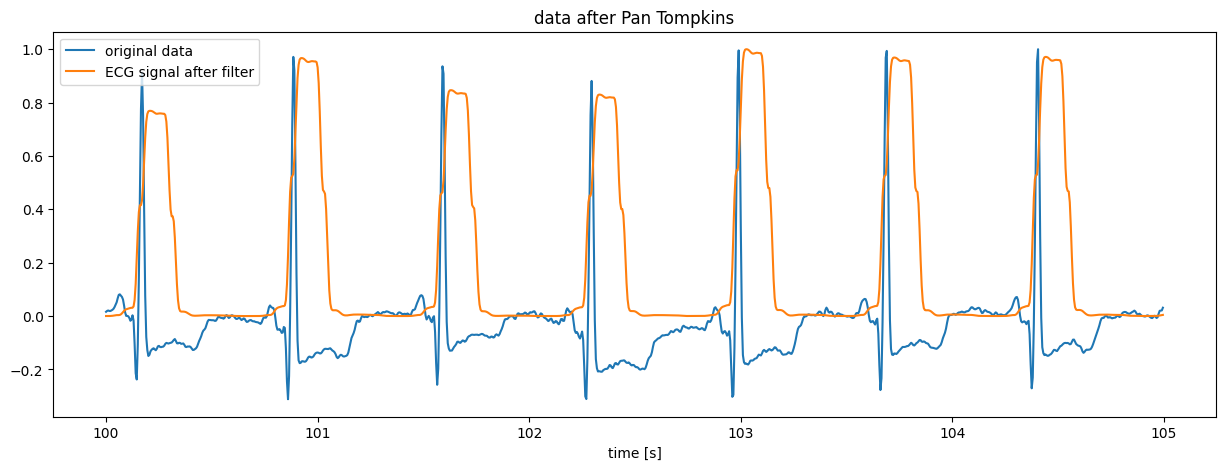

In [92]:

# Use the following code to plot the results of your Pan tompkins algorythm
path = Path('NilsPodX-9433_20191111_1039.csv')
test_time, test_signal = load_data_file(path)
filtered_signal = pan_tompkins(test_signal)

plt.figure(figsize=(15, 5))
plot_region = slice(100*200, 105*200)
plt.plot(test_time[plot_region], test_signal[plot_region]/test_signal[plot_region].max(), label='original data')
plt.plot(test_time[plot_region], filtered_signal[plot_region]/filtered_signal[plot_region].max(), label='ECG signal after filter')
plt.title('data after Pan Tompkins')
plt.xlabel('time [s]')
plt.legend();


## Ex 10.2: Pan-Tompkins 3 - Search strategy

After the signal is filtered, the Pan-Tomkins algorithm uses multiple adaptable thresholds to detect the now visible QRS-equivalent blocks.
For the sake of simplicity, we will use simple peak detection instead:

a) Have a look at multiple example files and decide on a suitable threshold that should include ideally all QRS-equivalent blocks.

b) Based on your knowledge of the physiological heart-rate of a human, calculate a lower limit for the peak-to-peak distance of two neighboring heartbeats.

c) Use scipy’s `find_peaks` function with both thresholds to detect QRS-Complexes. Validate your results at least on one additional dataset, you did not look at before.

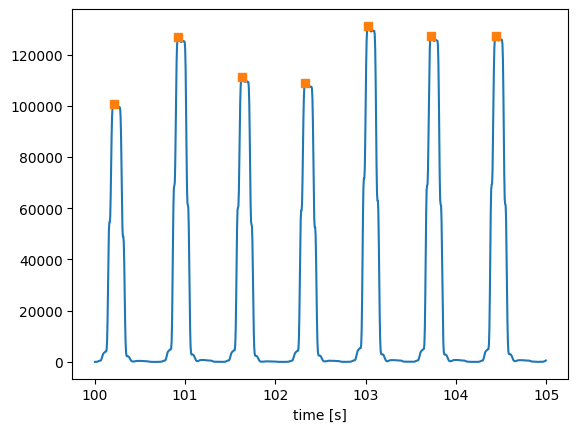

In [93]:
#Find peaks function and thresholding
MIN_HEIGHT = 40000
MIN_DISTANCE = 80

def find_r_peaks(pan_tom_out):
    # Create a function that finds the indivdual QRS-complexe in the output of the Pan Tompkins
    # YOUR CODE HERE


    return signal.find_peaks(pan_tom_out, height=MIN_HEIGHT,distance=MIN_DISTANCE)[0]

# Test your function by plotting the results together with the raw pan tompkins output.
# Check if the peaks on the graph are detected correctly

r_peaks = find_r_peaks(filtered_signal[plot_region])

plt.figure()
plt.plot(test_time[plot_region], filtered_signal[plot_region])
plt.plot(test_time[plot_region.start + r_peaks], filtered_signal[plot_region.start + r_peaks], 's')
plt.xlabel('time [s]');


In [94]:
##### THIS BLOCK HAS AUTOMATED GRADING PURPOSES, LEAVE IT AS IT IS


## Ex 10.3: Pan-Tompkins - Application 1: Heart rate

With all QRS complexes detected we can directly calculate the heart rate.

a) Calculate the heart-rate based on the R-R distances calculated in the previous step. Do **not** calculate the average heart-rate, but one value per R-R-Interval.

In [95]:
# Create a function that can calculate the heartrate based on the series of detected heartrates
def freq_from_peaks(peaks, sampling_rate):
    """Calculate the bpm frequency of events based on a list of occurrences.

    Args:
        peaks: list of indices at which the event occurs
        sampling_rate: sampling rate of the signal to transform the frequency to Hz

    Returns:
        All frequencies of events from the distances between the peaks in beats per minute (e.g. heartrate)
    """

    peaks = peaks.astype(float) # This prevents errors in the following lines
    distances = np.diff(peaks)
    distances /= sampling_rate
    freq = 1. / distances


    # Calculate the time differences between consecutive peaks
    rr_intervals = np.diff(peaks) / sampling_rate

    # Calculate heart rate in beats per minute (bpm)
    freq = 60 / rr_intervals
    return freq


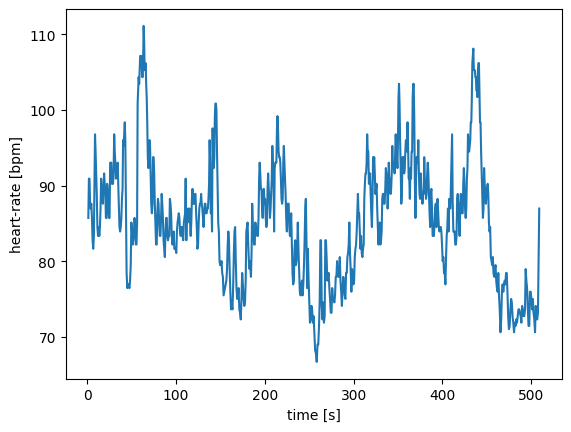

In [96]:
##~DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
# Use the following lines of code to test and plot your heartrate function

### BEGIN TESTS
test_peaks = np.ones(700)
test_peaks[2] = 100000
test_peaks[155] = 100000
test_peaks[278] = 100000
test_peaks[402] = 100000
test_peaks[512] = 100000
test_peaks[645] = 100000
test_peaks = find_r_peaks(test_peaks)

assert np.array_equal(np.trunc(freq_from_peaks(test_peaks, 200)),[78, 97,  96, 109, 90]),f"Your freq_from_peaks function is not working properly"
assert np.array_equal(np.trunc(freq_from_peaks(test_peaks, 45)),[17, 21, 21, 24, 20]),f"Your freq_from_peaks function is not working properly"

### END TESTS



r_peaks = find_r_peaks(filtered_signal)

heartrate = freq_from_peaks(r_peaks, 200)

plt.figure()
plt.plot(test_time[r_peaks[1:]], heartrate)
plt.xlabel('time [s]')
plt.ylabel('heart-rate [bpm]');





## Ex 10.4: Cold Face Test

The provided data are actually ECG recording of subjects undergoing a *cold face test*.
During the test, a cold face mask is applied to the participants face.
This triggers the so called “Diving Reflex”, which is usually associated with a reduction in heart rate.
This test can if the parasympathetic nervous system of the subject works as expected.

If you are interested in more information about the cold face test and the diving reflex have a look [here](https://en.wikipedia.org/wiki/Diving_reflex).

a) Create a function that extracts the Cold face test start time for all subjects from the file `./data/cft.csv`.

Note, that the function `load_data_file` removes the first 5 seconds of the signal.
Take this into account here, so that we can find the correct region in the signal later.

b) For the test subject used in the previous exercise (First recording in the cft file) extract the heart-rate in the region from 30 seconds before until 1 min after the cold face test. Calculate the mean heart-rate in the 30 seconds before, during and the 40 seconds after the test.

c) Set up a pipeline to perform all above calculations for all other recordings.

d) Visualize and comment the box plots representing the distribution of relative heart-rates in each of the 3 phases.

In [97]:
#a) Load the file ./data/cft.csv and extract the row corresponding to the recording you are working with
def read_cft_start(path):
    """Extract the cft start time for all subjects
    DO NOT CHANGE THE ORDER GIVEN IN cft.csv, IT IS IMPORTANT FOR GRADING PURPOSES

    Args:
        path: The path to the subject-specific file

    Returns:
        cft_start_subjects: A data frame with the columns "recording" and "cft_start" that contains the file number and
        its corresponding cold face test start time respectively. (Don't forget to remove 5 seconds from all the start
        times)

    Example output:
            recording  cft_start
0  9433_20191111_1039        145
1  9433_20191111_1101        175
2  ...                       ...
...

   """
    # YOUR CODE HERE
    data_path = pd.read_csv(path)
    cft_start_subjects = data_path[['recording', 'cft_start']]
    cft_start_subjects['cft_start'] -= 5
    return cft_start_subjects


In [98]:
##~DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
#Test your read_cft_start function implementation


### BEGIN TESTS
cftpath = 'cft.csv'
cft_start_subjects = read_cft_start(cftpath)
print(cft_start_subjects)

assert not cft_start_subjects.iloc[0,1]==180,f"Your function is not working properly, you probably forgot to substract 5 seconds from the start time"
assert cft_start_subjects.iloc[3,1]==235,f"Your function is not working properly"
assert cft_start_subjects.iloc[5,1]==165,f"Your function is not working properly"
assert cft_start_subjects.iloc[0,0]=="9433_20191111_1039",f"Your function is not working properly, check if the names are being saved properly"
assert cft_start_subjects.iloc[6,0]=="9E82_20191111_1111",f"Your function is not working properly, check if the names are being saved properly"
### END TESTS

print("\n\t\t\t\t All tests Complete :) \n")

            recording  cft_start
0  9433_20191111_1039        145
1  9433_20191111_1101        175
2  9433_20191111_1111        175
3  9433_20191111_1126        235
4  9433_20191111_1137        175
5  9E82_20191111_1102        165
6  9E82_20191111_1111        175
7  9E82_20191111_1126        235
8  9E82_20191111_1138        175

				 All tests Complete :) 



In [99]:
# b) Create a function that extracts the 3 relevant regions from the detected r-Peaks
# calculates the heartrate for each region and takes the average over them

def extract_cft_heart_rates(r_peaks, sampling_rate, cft_start):
    """Extract the heartrates around the cold face test.

    Args:
        r_peaks: series of r peaks detected in the signal
        sampling_rate: The sampling rate of the recording (Hz)
        cft_start: The start of the cold face test in seconds

    Returns:
        average heart-rates for the following regions:
        -30 to cft_start, cft_start to cft_end (cft_start+60), cft_end to cft_end + 40
    """
    # YOUR CODE HERE
    A1 = cft_start - 30
    A2 = A1 + 30
    B1 = A2
    B2 = B1 + 60
    C1 = B2
    C2 = C1 + 40


    intervals = r_peaks / sampling_rate

    # Define the intervals using alternative variables
    interval_A = intervals[(intervals >= A1) & (intervals <= A2)]
    interval_B = intervals[(intervals >= B1) & (intervals <= B2)]
    interval_C = intervals[(intervals >= C1) & (intervals <= C2)]

    # Assign to filtered arrays
    filtered_1 = interval_A
    filtered_2 = interval_B
    filtered_3 = interval_C


    heart_rates_e =60/( np.diff(filtered_1))
    heart_rates_g =60/(np.diff(filtered_2))
    heart_rates_ar =60/(np.diff(filtered_3))

    mean_heart_rates = np.array([int(np.mean(heart_rates_e)),int( np.mean(heart_rates_g)), int(np.mean(heart_rates_ar))])

    return mean_heart_rates




In [100]:
##~DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
# Test your extract_cft_heart_rates function
heart_rates = extract_cft_heart_rates(r_peaks, 200, cft_start_subjects.iloc[0,1])
print(heart_rates)

### BEGIN TESTS
#Test your outputs
assert np.array_equal([78,86,76],np.trunc(extract_cft_heart_rates(r_peaks, 200, cft_start_subjects.iloc[1,1]))),f"Your calculated heartrates do not match the required results"

assert np.array_equal([84,85,77],np.trunc(extract_cft_heart_rates(r_peaks, 200, cft_start_subjects.iloc[5,1]))),f"Your calculated heartrates do not match the required results"

### END TESTS

print("\n\t\t\t\t All tests passed \n")

[88 81 86]

				 All tests passed 



In [101]:
# c) Create a loop over all subjects and repeat the calculation
# Accumulate all results in a pandas dataframe

def heart_rates_calculator(cft_start_subjects):
    """
    Extract the average heartrates of all the test subjects during the 3 specified phases:
    The First column should have the average of the first phase
    The Second column should have the average of the second phase
    The Third column should have the average of the third phase

    The INDEX NAME of the dataframe should be the subject number (not just an additional column)

    Returns:
    Pandas dataframe with 3 columns corresponding to the 3 phases HR average for each subject

    Example Output:

                        p1         p2         p3
9433_20191111_1039  88.680265  81.795984  86.503153
9433_20191111_1101  84.625673  75.080298  81.764850
...
...

    """
    all_heart_rates = pd.DataFrame()

    # YOUR CODE HERE

    all_heart_rates1 = []
    all_heart_rates = pd.DataFrame(columns=['Recording'])
    i=0
    for index, row in cft_start_subjects.iterrows():
        record = row['recording']
        cft_start = row['cft_start']
        # Load data file using the recording information
        sub = Path('/content') / f'NilsPodX-{record}.csv'

        time, ecg_signal = load_data_file(sub)
        filtered_signal = pan_tompkins(ecg_signal)
        r_peaks = find_r_peaks(filtered_signal)

        heart_rates = extract_cft_heart_rates(r_peaks, 200, cft_start)
        all_heart_rates1.append(heart_rates)
        #print('all_heart_rates1',all_heart_rates1,type(all_heart_rates1))
        extracted_list = all_heart_rates1[i].tolist()

        i+=1
        all_heart_rates = pd.concat([all_heart_rates, pd.DataFrame({'Recording': [record], 'p1': [extracted_list[0]], 'p2': [extracted_list[1]], 'p3': [extracted_list[2]]})], ignore_index=True)

    all_heart_rates.set_index('Recording', inplace=True)
    return all_heart_rates




In [102]:
##~DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
#Test your heart_rates_calculator function implementation here
all_heart_rates = heart_rates_calculator(cft_start_subjects)
print(all_heart_rates)


#Test your outputs

### BEGIN TESTS

##Change to use iloc with names
assert np.trunc(all_heart_rates.loc["9433_20191111_1039", "p1"])==88, f"The output calculated does not match the desired results"
assert np.trunc(all_heart_rates.loc["9433_20191111_1137", "p3"])==68, f"The output calculated does not match the desired results"
assert np.trunc(all_heart_rates.loc["9E82_20191111_1111", "p2"])==63, f"The output calculated does not match the desired results"
assert np.trunc(all_heart_rates.loc["9E82_20191111_1138", "p3"])==76, f"The output calculated does not match the desired results"

### END TESTS

print("\n\t\t\t\t Test complete :) \n")

                      p1    p2    p3
Recording                           
9433_20191111_1039  88.0  81.0  86.0
9433_20191111_1101  84.0  75.0  81.0
9433_20191111_1111  87.0  81.0  86.0
9433_20191111_1126  69.0  73.0  68.0
9433_20191111_1137  66.0  67.0  68.0
9E82_20191111_1102  76.0  71.0  77.0
9E82_20191111_1111  67.0  63.0  76.0
9E82_20191111_1126  65.0  63.0  74.0
9E82_20191111_1138  78.0  74.0  76.0

				 Test complete :) 



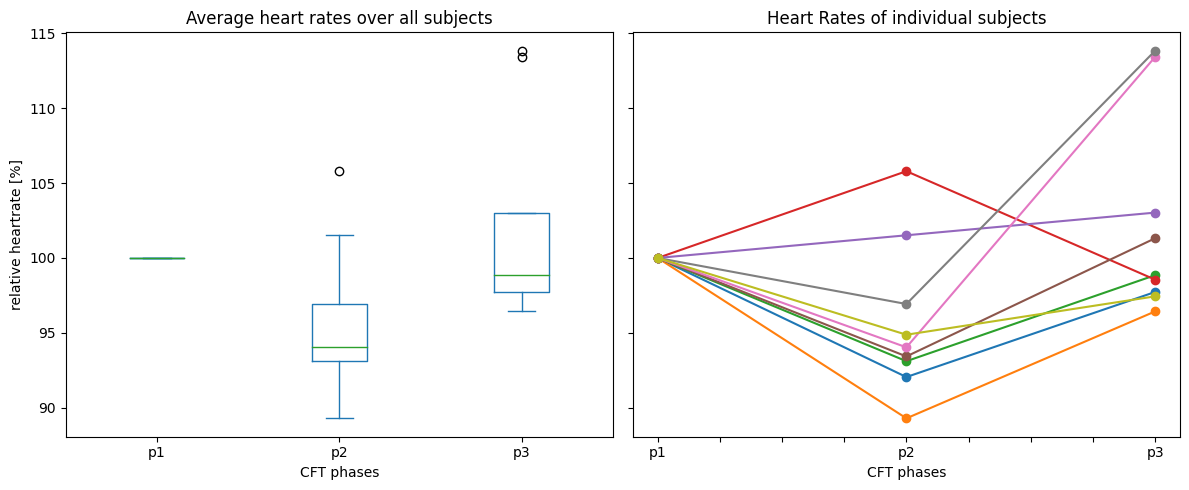

In [103]:
# d) You can visualize your previous results in boxplots with the following code
rel_heart_rates = pd.DataFrame()
rel_heart_rates["p1"] = all_heart_rates["p1"]/all_heart_rates["p1"]
rel_heart_rates["p2"] = all_heart_rates["p2"]/all_heart_rates["p1"]
rel_heart_rates["p3"] = all_heart_rates["p3"]/all_heart_rates["p1"]

rates_df = pd.DataFrame(rel_heart_rates * 100)


fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
rates_df.plot.box(ax=ax1)
ax1.set_title('Average heart rates over all subjects')
ax1.set_ylabel('relative heartrate [%]')
ax1.set_xlabel('CFT phases')

rates_df.T.plot.line(style='-o', legend=False, ax=ax2)
ax2.set_title('Heart Rates of individual subjects')
ax2.set_xlabel('CFT phases')

plt.tight_layout()
